In [1]:
import numpy as np
import math as ma
import matplotlib.pyplot as plt

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

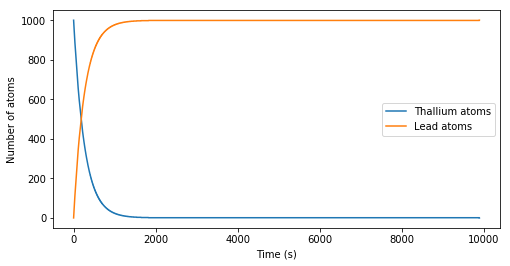

In [2]:
#computation with 1 second steps
#initial sample
Tl_in=1000 
Pb_in=0


#probability
def p(t):
    #half-life
    tau = 3.052*60 #seconds
    return 1-2**(-t/tau)

Tl=[Tl_in]
Pb=[Pb_in]
i=0
while Tl[i] != 0:
    i += 1
    Tl.append(Tl_in - int(p(i)*1000))
    Pb.append(int(p(i)*1000))


#plot  
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(np.arange(len(Tl)), Tl, label = 'Thallium atoms')
ax.plot(np.arange(len(Pb)), Pb, label = 'Lead atoms')
#ax.plot(np.ones(1000)*3.052*60, np.arange(1000), label = 'Half-life')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Number of atoms');

In [3]:
#computation with inverse trasform method

#probability
def p(t):
    #half-life
    tau = 3.052*60 #seconds
    return 2**(t/tau)*ma.log(2)/tau

The PDF is 
$$
p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}
$$

The CDF is: 
$$
\int_{0}^{t(z)} p(t') dt' = \int_{0}^{t(z)} 2^{-t'/\tau}\frac{\ln 2}{\tau}dt' = -2^{-t/\tau} = z
$$

The inverse CDF is:

$$
t(z) = -\tau \log_2 (-z)
$$

The number of atoms that remain at 2456.6552555110493 (s) are 9.152030734083105e-05 .


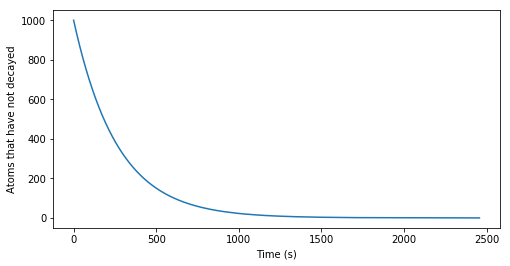

In [4]:
#uniform distribution
z=np.sort(np.random.uniform(0,1,1000))

#t(z)
def t(z):
    #half-life
    tau = 3.052*60 #seconds
    return -tau*np.log2(z)

print('The number of atoms that remain at', t(z[0]), '(s) are', z[0],'.')


#plot  
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(t(z),z*1000)
#ax.plot(np.ones(1000)*3.052*60, np.arange(1000), label = 'Half-life')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Atoms that have not decayed');

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

##### Solution

If the scattering angle is equal to $\frac{\pi}{2}$,
$$
\tan{\frac{\pi}{4}} = 1 = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$ 


In order to obtain a scattering angle greater than $\frac{\pi}{2}$ the impact parameter b must be

$$
b< \frac  {Z e^2}{2\pi \epsilon_0 E }
$$

In [5]:
#number of alpha particle
a=1000000

#beam
a0=52.92 #pm
std=a0/100
mean = [0, 0]
cov = [[std, 0], [0, std]]  # diagonal covariance
x, y = np.random.multivariate_normal(mean, cov, a).T

#parameters
Z=79
E=7.7*1.602176565e-13 #J
e0=8.85418781762e-24 #F/pm= C^2/ Jpm
e=-1.602176565e-19 #C

#computation
b_pi2 = (Z*e**2)/(2*ma.pi*e0*E)
b = np.sqrt(np.power(x,2)+np.power(y,2))

bounce_back=b.copy()
n_bounce_back=len(bounce_back[b <  b_pi2])

print('The number of the particles that "bounce back" is',n_bounce_back)
#print(b_pi2, 'pm')

The number of the particles that "bounce back" is 816


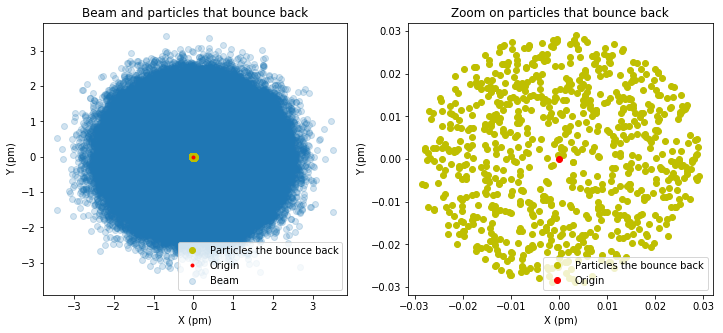

In [6]:
#plot  
coor=np.zeros((2,n_bounce_back))
c=0
for i in range(0,a):
    if b[i] < b_pi2:
        coor[0,c]=x[i]
        coor[1,c]=y[i] 
        c += 1
    
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax1.scatter(x,y, alpha=0.2, label='Beam')
ax1.plot(coor[0,:],coor[1,:], 'yo', label='Particles the bounce back' )
ax1.plot(0,0,'r.', label='Origin')
ax1.legend()
ax1.set_xlabel('X (pm)')
ax1.set_ylabel('Y (pm)')
ax1.set_title('Beam and particles that bounce back')

ax2.plot(coor[0,:],coor[1,:], 'yo', label='Particles the bounce back' )
ax2.plot(0,0,'ro', label='Origin')
ax2.legend()
ax2.set_xlabel('X (pm)')
ax2.set_ylabel('Y (pm)')
ax2.set_title('Zoom on particles that bounce back');

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [7]:
def f(x):
    return (ma.sin(1/(x*(2-x))))**2

##### Hit/miss method

Integral obtained with hit/miss method 1.4496


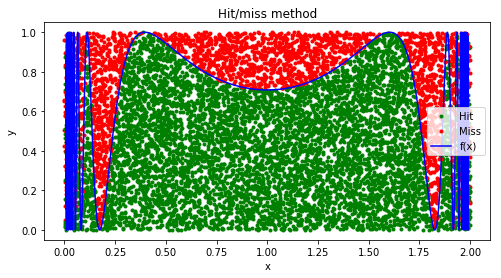

In [8]:
N=10000

#plot
fig, ax = plt.subplots(figsize=(8,4))


count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): 
        count+=1
        hit, = ax.plot(x,y, 'g.')
    else:
        miss, = ax.plot(x,y, 'r.')

hit.set_label('Hit')
miss.set_label('Miss')
x=np.linspace(0.01,1.99,N)
ax.plot(x, (np.sin(1/(x*(2-x))))**2, 'b-', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Hit/miss method')

I_hm=2*count/N
print('Integral obtained with hit/miss method',I_hm)

###### Error on Hit/Miss method

The integral is computed M times and the error is the standard deviation:

$$\sigma_{hit/miss} =  \sqrt{\frac{\sum_{i=1}^M \left(I_i -\bar{I}\right)^2}{M-1}}$$

where $\bar{I}$ is the integral computed above.

In [9]:
#set M to 15
M=15

Ii=np.zeros(M)

for j in range(M):
    count=0
    for i in range(N):
        x=2*np.random.random()
        y=np.random.random()
        if y<f(x): 
            count+=1
    Ii[j]=2*count/N

std_hm= ma.sqrt((np.sum(Ii-I_hm))**2/(M-1))

print('Error on hit/miss method',std_hm)

Error on hit/miss method 0.008338550747667612


##### Mean value method

In [10]:
N=10000
a=0.001
b=1.999
x=np.random.uniform(a,b,N)
sumf=0
for i in range(N):
    sumf += f(x[i])
I_mv=(b-a)/N * sumf 
print('Integral obtained with mean value method',I_mv)


Integral obtained with mean value method 1.4482686835422889


###### Error on Mean value method

$$\sigma_{mean \, value} = V \frac{\sqrt{\text{var}\, f}}{\sqrt{N}}$$

The variance of f is: $\text{var} \, f = <f^2> - <f>^2$ where $<f>$ is the mean of f defined as $<f> = \frac{1}{2-0}\int^2_0 f(x) dx$.

* $<f>$ \: $\, \,$ Since $I = \int^2_0 f(x) dx$, $\, \,$ $<f> = \frac{I}{2-0}$



* $<f^2>$ \: $\, \,$ It is necessary to compute $I_2= \int_0^2 f(x)^2 dx$, $\, \,$ $<f^2> = \frac{I_2}{2-0}$

In [11]:
#<f>
f_m = I_mv/2

#<f^2>
sumf=0
for i in range(N):
    fi=f(x[i])
    sumf += fi**2
    
f2_m=sumf / N

var=f2_m-f_m**2

std_mv = 2*ma.sqrt(var)/ma.sqrt(N)

print('Error mean value method', std_mv)

Error mean value method 0.005321782914703099


##### Comparison on hit/miss and mean value methods

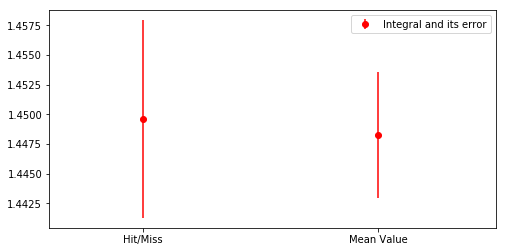

In [12]:
fig, ax = plt.subplots(figsize=(8,4))

x=[0,0.5]
y=[I_hm, I_mv]
std=[std_hm, std_mv]
ax.errorbar(x,y,std, fmt='ro',ecolor='r', label='Integral and its error')
ax.legend()
ax.set_xlim(-0.2, 0.75)
plt.xticks(x, ('Hit/Miss', 'Mean Value'));

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



##### Area of the circle

In [13]:
def f(x,y):
    if x**2+y**2 <=1: return 1
    else: return 0

Integral obtained with hit/miss method 3.1352


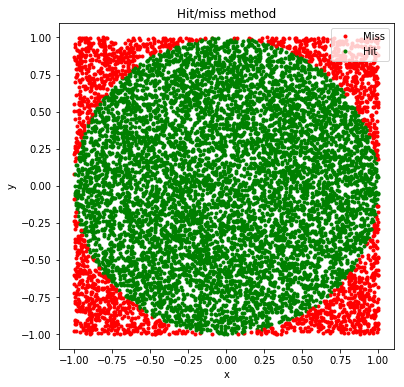

In [14]:
#hit/miss
N=10000

#plot
fig, ax = plt.subplots(figsize=(6,6))

count=0
for i in range(N):
    a=np.random.random()
    b=np.random.random()
    if a >0.5: signx=1
    else: signx=-1
    if b >0.5: signy=1
    else: signy=-1
    x=signx*np.random.random()
    y=signy*np.random.random()
    z=np.random.random()
    if z<f(x,y): 
        count += 1
        hit, = ax.plot(x,y, 'g.')
    else: 
        miss, = ax.plot(x,y, 'r.')
 

hit.set_label('Hit')
miss.set_label('Miss')
ax.legend()   
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Hit/miss method')

I=4*count/N
print('Integral obtained with hit/miss method',I)

In [15]:
#mean method
N=10000
a=-1
b=1
x=np.random.uniform(a,b,N)
y=np.random.uniform(a,b,N)
sumf=0
for i in range(N):
    sumf += f(x[i],y[i])
    
I=(b-a)*(b-a)/N * sumf 
print('Integral obtained with mean value method',I)

Integral obtained with mean value method 3.1392


##### Integral of 10D sphere

In [16]:
def f(x):
    s=0
    for i in range(10): 
        s += (x[i])**2
    if s <=1: return 1
    else: return 0

In [17]:
#hit/miss
N=100000

count=0

for i in range(0,N):
    sign=[] #for the sign
    x=[] #variables
    for j in range(0,10):
        a=np.random.random()
        if a > 0.5: sign.append(1)
        else: sign.append(-1)
    for j in range(0,10):
        x.append(sign[j]*np.random.random())
        
    z=np.random.random()
    if z<f(x): 
        count += 1

A=2**10

I=A*count/N
print('Integral obtained with hit/miss method',I)

Integral obtained with hit/miss method 2.3552


In [18]:
#mean method
N=100000
a=-1
b=1

x=np.zeros((10,N))
for i in range(10):
    x[i]=np.random.uniform(a,b,N)
    
sumf=0
for i in range(N):
    sumf += f(x[:,i])
    
I=(b-a)**10/N * sumf 
print('Integral obtained with mean value method',I)

Integral obtained with mean value method 2.6624000000000003


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [19]:
def f(x):
    return 1/(np.sqrt(x)*(np.exp(x)+1))

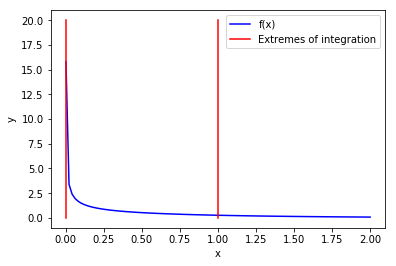

In [20]:
#plot
fig, ax = plt.subplots(figsize=(6,4))
x=np.linspace(0.001,2,100)
y=np.linspace(0,20,100)

ax.plot(x,f(x),'b',label='f(x)')
ax.plot(np.zeros(100),y,'r', label='Extremes of integration')
ax.plot(np.ones(100),y,'r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend();

With importance sampling the integral is computed as 

$$ I \simeq \frac{1}{N} \sum_{i=1}^N \frac{f(x_i)}{w(x_i)} \int_0^1 w(x) dx = \frac{1}{N} \sum_{i=1}^N \frac{1}{e^{x_i}+1} \int_0^1 \frac{1}{\sqrt{x}} dx = \frac{2}{N} \sum_{i=1}^N \frac{1}{e^{x_i}+1}$$

where $\int_0^1 1/\sqrt{x} dx = \left[2\sqrt{x}\right]_0^1 = 2$

In [21]:
N = 1000000
#define f(x)/w(x)
def f_div_w(x):
    return 1/(np.exp(x)+1)

#compute the integral

x=np.linspace(0,1,N)
s=np.sum(f_div_w(x))
I=(2/N) * s

print('The integral is:',I)

The integral is: 0.7597709952538892
